In [2]:
%matplotlib widget
import pdal
import json
import numpy as np
from shapely.geometry import Polygon
from shapely.ops import transform
from pyproj import Proj, Transformer, CRS
import rioxarray as rio
import matplotlib.pyplot as plt
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt


## From Point Clouds

### Get point clouds through OpenTopography

### User-provided files

If you already have .las or .laz point cloud files for your compare and reference datasets, this section is for you. 

#### Functions

Defines a series of functions designed to handle coordinate reference systems (CRS) and perform geospatial operations on point clouds and polygons.

	•	get_epsg_from_wkt(wkt): This function takes a Well-Known Text (WKT) representation of a CRS and returns the corresponding EPSG code. It creates a CRS object from the WKT and retrieves the EPSG code with a minimum confidence level.

	•	determine_utm_epsg(polygon): This function determines the EPSG code for the UTM zone of a given Shapely polygon in EPSG:4326. It calculates the centroid of the polygon, determines the UTM zone based on the centroid’s longitude, and constructs the UTM CRS. If the automatic conversion to EPSG fails, it provides a manual fallback based on the hemisphere.

	•	reproject_polygon(polygon, current_epsg, target_epsg): This function reprojects a Shapely polygon from one EPSG code to another. It uses a transformer to apply the coordinate transformation and returns the reprojected polygon.
	
	•	get_utm_epsg_code_and_boundary_poly(point_cloud): This function retrieves the original EPSG code, UTM EPSG code, and the boundary polygon in UTM coordinates for a given point cloud. It reads the point cloud metadata using a PDAL pipeline, extracts the WKT and EPSG code, defines the bounding polygon, and reprojects it to the UTM CRS.



In [2]:
def get_epsg_from_wkt(wkt):
    """
    Retrieves the EPSG code from a Well-Known Text (WKT) representation of a coordinate reference system (CRS).

    :param wkt: Well-Known Text representation of the CRS.
    :return: EPSG code corresponding to the CRS.
    """
    # Create a CRS object from the WKT
    crs = CRS.from_wkt(wkt)
    
    # Get the EPSG code with a minimum confidence level of 25
    return crs.to_epsg(min_confidence=25)

def determine_utm_epsg(polygon):
    """
    Determines the EPSG code for the UTM zone of a Shapely polygon given in EPSG:4326 using pyproj.

    :param polygon: Shapely Polygon object in EPSG:4326.
    :return: string representing the EPSG code of the UTM zone where the polygon is located.
    """
    # Ensure the input is a Polygon
    if not isinstance(polygon, Polygon):
        raise ValueError("Input must be a shapely Polygon.")
    
    # Calculate the centroid of the polygon
    centroid = polygon.centroid
    longitude = centroid.x
    latitude = centroid.y

    # Calculate UTM zone number based on longitude
    zone_number = int((longitude + 180) / 6) + 1

    # Determine hemisphere based on latitude
    hemisphere = 'north' if latitude >= 0 else 'south'
    
    # Construct UTM CRS based on centroid longitude and hemisphere
    utm_crs_proj = Proj(f"+proj=utm +zone={zone_number} +{hemisphere} +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
    
    # Convert the UTM CRS into an EPSG code using pyproj CRS object
    utm_crs = CRS(utm_crs_proj.srs)
    epsg_code = utm_crs.to_epsg()  # This should automatically determine the appropriate EPSG code

    # If pyproj fails to directly convert to EPSG, use a manual fallback
    if epsg_code is None:
        epsg_code = f"326{zone_number}" if hemisphere == 'north' else f"327{zone_number}"

    return str(epsg_code)

def reproject_polygon(polygon, current_epsg, target_epsg):
    """
    Reprojects a Shapely polygon from one EPSG code to another.

    :param polygon: Shapely Polygon object.
    :param current_epsg: EPSG code of the polygon's current coordinate system.
    :param target_epsg: EPSG code of the target coordinate system.
    :return: A new Shapely Polygon object in the target coordinate system.
    """
    # Create a transformer between the current CRS and the target CRS
    transformer = Transformer.from_crs(f"EPSG:{current_epsg}", f"EPSG:{target_epsg}", always_xy=True)
    
    # Function to apply the transformation to each coordinate
    def apply_transform(x, y):
        return transformer.transform(x, y)

    # Apply the transformation to the polygon
    reprojected_polygon = transform(apply_transform, polygon)
    
    return reprojected_polygon

def get_utm_epsg_code_and_boundary_poly(point_cloud):
    """
    Retrieves the original EPSG code, the UTM EPSG code, and the boundary polygon in UTM coordinates for a given point cloud.

    :param point_cloud: Path to the point cloud file.
    :return: Tuple containing the original EPSG code, the UTM EPSG code, and the boundary polygon in UTM coordinates.
    """
    # Create a PDAL pipeline to read point cloud and extract metadata
    read_pipeline_json = json.dumps({
        "pipeline": [
            {
                "type": "readers.las",
                "filename": point_cloud
            },
            {
                "type": "filters.stats",
                "dimensions": "X,Y,Z",
                "global": True
            },
            {
                "type": "filters.info",
            }
        ]
    })
    
    # Execute the PDAL pipeline
    read_pipeline = pdal.Pipeline(read_pipeline_json)
    read_pipeline.execute()
    
    # Extract metadata from the pipeline
    metadata = read_pipeline.metadata
    
    # Get the original WKT and EPSG code from the metadata
    original_wkt = metadata['metadata']['filters.info']['srs']['wkt']
    original_epsg_code = get_epsg_from_wkt(original_wkt)
    
    # Define polygon from data bounding box in EPSG:4326
    coords_list = metadata['metadata']['filters.stats']['bbox']['EPSG:4326']['boundary']['coordinates'][0]
    coords = [(coords_list[a][0], coords_list[a][1]) for a in range(len(coords_list))]
    boundary_polygon = Polygon(coords)

    # Get the EPSG code for the UTM zone
    utm_epsg_code = determine_utm_epsg(boundary_polygon)
    
    # Reproject boundary polygon to UTM CRS
    boundary_polygon_utm = reproject_polygon(boundary_polygon, '4326', utm_epsg_code)
    
    return original_epsg_code, utm_epsg_code, boundary_polygon_utm  

#### Implementation

In [44]:
# Define the path to the data directory
data_path = 'CO_data/'

# Define the paths to the point cloud files
compare_cloud_path = data_path + 'compare.laz'
reference_cloud_path = data_path + 'reference.laz'

# Get the original EPSG code, UTM EPSG code, and boundary polygon in UTM coordinates for the compare (older) point cloud
original_epsg_code1, utm_epsg_code1, boundary_polygon_utm1 = get_utm_epsg_code_and_boundary_poly(compare_cloud_path)

# Get the original EPSG code, UTM EPSG code, and boundary polygon in UTM coordinates for the reference (newer) point cloud
original_epsg_code2, utm_epsg_code2, boundary_polygon_utm2 = get_utm_epsg_code_and_boundary_poly(reference_cloud_path)

In [46]:
print('Original CRS:') 
print(f'                Compare:   EPSG: {original_epsg_code1};')
print(f'                Reference: EPSG: {original_epsg_code2};')
print('WGS84 Projected CRS:') 
print(f'                Compare:   EPSG: {utm_epsg_code1};')
print(f'                Reference: EPSG: {utm_epsg_code2};')

Original CRS:
                Compare:   EPSG: 32613;
                Reference: EPSG: 32613;
WGS84 Projected CRS:
                Compare:   EPSG: 32613;
                Reference: EPSG: 32613;


### Find area of overlap

In [47]:
def find_intersection_polygon(polygon1, polygon2):
    """
    Finds the intersection of two Shapely polygons.

    :param polygon1: First Shapely Polygon object.
    :param polygon2: Second Shapely Polygon object.
    :return: A new Shapely Polygon object representing the intersection, or None if there is no intersection.
    """
    # Compute the intersection of the two polygons
    intersection_polygon = polygon1.intersection(polygon2)

    # Check if the intersection is not empty
    if not intersection_polygon.is_empty:
        return intersection_polygon
    else:
        return None

In [48]:
intersection_polygon = find_intersection_polygon(boundary_polygon_utm1, boundary_polygon_utm2)

## Make DEMs

#### Functions

In [49]:
def build_pdal_pipeline(filename, extent, filterNoise=False, reclassify=False, savePointCloud=True, outCRS=3857, 
                        pc_outName='filter_test', pc_outType='laz'):
    """
    Build PDAL pipeline for requesting, processing, and saving point cloud data. Each processing step is a 'stage' 
    in the final PDAL pipeline. Each stage is appended to the 'pointcloud_pipeline' object to produce the final pipeline.
    
    Parameters:
    filename (str): Path to LAZ file with point cloud.
    extent (shapely polygon): Intersection of dataset boundary polygons or user-generated polygon.
    filterNoise (bool): Option to remove points from USGS Class 7 (Low Noise) and Class 18 (High Noise).
    reclassify (bool): Option to remove USGS classes and run SMRF to classify ground points only. Default is False.
    savePointCloud (bool): Option to save (or not) the point cloud data. If savePointCloud is False, 
           the pc_outName and pc_outType parameters are not used and can be any value.
    outCRS (int): Output coordinate reference system (CRS), specified by EPSG code.
    pc_outName (str): Desired name of the file on the user's local file system. If savePointCloud is False, 
                  pc_outName can be any value.
    pc_outType (str): Desired file extension. Input must be either 'las' or 'laz'. If savePointCloud is False, 
                  pc_outName can be any value. If a different file type is requested, the user will get an error.
    
    Returns:
        pointcloud_pipeline (dict): Dictionary of processing stages in sequential order that define the PDAL pipeline.

    Raises: 
        Exception: If user passes in an argument that is not 'las' or 'laz'.
    """
        
    # Initialize the pipeline with reading and cropping stages
    pointcloud_pipeline = [
        {
            "type": "readers.las",
            "filename": filename
        },
        {
            "type": "filters.crop",
            "polygon": extent.wkt
        }
    ]
    
    # Optionally add a noise filter stage
    if filterNoise:
        pointcloud_pipeline.append({
            "type": "filters.range",
            "limits": "Classification![7:7], Classification![18:18]"
        })
    
    # Optionally add reclassification stages
    if reclassify:
        pointcloud_pipeline += [
            {"type": "filters.assign", "value": "Classification = 0"},
            {"type": "filters.smrf"},
            {"type": "filters.range", "limits": "Classification[2:2]"}
        ]
    
    # Add reprojection stage
    pointcloud_pipeline.append({
        "type": "filters.reprojection",
        "out_srs": f"EPSG:{outCRS}"
    })
    
    # Optionally add a save point cloud stage
    if savePointCloud:
        if pc_outType not in ['las', 'laz']:
            raise Exception("pc_outType must be 'las' or 'laz'.")
        
        writer_stage = {
            "type": "writers.las",
            "filename": f"{pc_outName}.{pc_outType}"
        }
        if pc_outType == 'laz':
            writer_stage["compression"] = "laszip"
        
        pointcloud_pipeline.append(writer_stage)
        
    return pointcloud_pipeline

def make_DEM_pipeline(filename, extent, dem_resolution,
                      filterNoise=True, reclassify=False, savePointCloud=False, outCRS=3857,
                      pc_outName='filter_test', pc_outType='laz', demType='dtm', gridMethod='idw', 
                      dem_outName='dem_test', dem_outExt='tif', driver="GTiff"):
    """
    Build PDAL pipeline for creating a digital elevation model (DEM) product from the requested point cloud data. The 
    user must specify whether a digital terrain model (DTM) or digital surface model (DSM) will be created, 
    the output DTM/DSM resolution, and the gridding method desired. The user may define any processing steps (filtering, reclassifying, reprojecting). The user must also specify whether 
    the point cloud should be saved or not. Saving the point cloud is not necessary for the generation of the DEM. 

    Parameters:
        filename (str): Path to LAZ file with point cloud.
        extent (shapely polygon): Intersection of dataset boundary polygons or user-generated polygon.
        dem_resolution (float): Desired grid size (in meters) for the output raster DEM.
        filterNoise (bool): Option to remove points from USGS Class 7 (Low Noise) and Class 18 (High Noise).
        reclassify (bool): Option to remove USGS classes and run SMRF to classify ground points only. Default is False.
        savePointCloud (bool): Option to save (or not) the point cloud data. If savePointCloud is False, the pc_outName 
                               and pc_outType parameters are not used and can be any value.
        outCRS (int): Output coordinate reference system (CRS), specified by EPSG code (e.g., 3857 - Web Mercator).
        pc_outName (str): Desired name of the file on the user's local file system. If savePointCloud is False, 
                          pc_outName can be any value.
        pc_outType (str): Desired file extension. Input must be either 'las' or 'laz'. If a different file type is requested,
                    the user will get an error stating "Extension must be 'las' or 'laz'". If savePointCloud is False, 
                    pc_outName can be any value.
        demType (str): Type of DEM produced. Input must be 'dtm' (digital terrain model) or 'dsm' (digital surface model).
        gridMethod (str): Method used. Options are 'min', 'mean', 'max', 'idw'.
        dem_outName (str): Desired name of the DEM file on the user's local file system.
        dem_outExt (str): DEM file extension. Default is TIF.
        driver (str): File format. Default is GTiff.
    
    Returns:
        dem_pipeline (dict): Dictionary of processing stages in sequential order that define the PDAL pipeline.
        
    Raises: 
        Exception: If user passes in an argument that is not 'las' or 'laz'.
        Exception: If user passes in an argument that is not 'dtm' or 'dsm'.
    """

    # Build the base point cloud pipeline using the provided parameters
    pointcloud_pipeline = build_pdal_pipeline(filename, extent, filterNoise, reclassify, savePointCloud, outCRS, pc_outName, pc_outType)
    
    # Prepare the base pipeline dictionary
    dem_pipeline = {
        "pipeline": pointcloud_pipeline
    }

    # Add appropriate stages based on DEM type
    if demType == 'dsm':
        # Directly add the DSM writer stage
        dem_pipeline['pipeline'].append({
            "type": "writers.gdal",
            "filename": f"{dem_outName}.{dem_outExt}",
            "gdaldriver": driver,
            "nodata": -9999,
            "output_type": gridMethod,
            "resolution": float(dem_resolution),
            "gdalopts": "COMPRESS=LZW,TILED=YES,blockxsize=256,blockysize=256,COPY_SRC_OVERVIEWS=YES"
        })
    
    elif demType == 'dtm':
        # Add a filter to keep only ground points
        dem_pipeline['pipeline'].append({
            "type": "filters.range",
            "limits": "Classification[2:2]"
        })

        # Add the DTM writer stage
        dem_pipeline['pipeline'].append({
            "type": "writers.gdal",
            "filename": f"{dem_outName}.{dem_outExt}",
            "gdaldriver": driver,
            "nodata": -9999,
            "output_type": gridMethod,
            "resolution": float(dem_resolution),
            "gdalopts": "COMPRESS=LZW,TILED=YES,blockxsize=256,blockysize=256,COPY_SRC_OVERVIEWS=YES"
        })
    else:
        raise Exception("demType must be 'dsm' or 'dtm'.")
    
    return dem_pipeline

#### Implementation

In [50]:
dem_resolution =1.0
compare_dtm_pipeline = make_DEM_pipeline(compare_cloud_path, intersection_polygon, dem_resolution,
                      filterNoise = True, reclassify = False, savePointCloud = False, outCRS = utm_epsg_code1,
                      pc_outName = 'filter_test', pc_outType = 'laz', demType = 'dtm', gridMethod = 'idw', # natural neighbors?
                      dem_outName = data_path+'compare_dtm', dem_outExt = 'tif', driver = "GTiff")
compare_dtm_pipeline = pdal.Pipeline(json.dumps(compare_dtm_pipeline))
compare_dtm_pipeline.execute_streaming(chunk_size=1000000)

compare_dsm_pipeline = make_DEM_pipeline(compare_cloud_path, intersection_polygon, dem_resolution,
                      filterNoise = True, reclassify = False, savePointCloud = False, outCRS = utm_epsg_code1,
                      pc_outName = 'filter_test', pc_outType = 'laz', demType = 'dsm', gridMethod = 'max', 
                      dem_outName = data_path+'compare_dsm', dem_outExt = 'tif', driver = "GTiff")
compare_dsm_pipeline = pdal.Pipeline(json.dumps(compare_dsm_pipeline))
compare_dsm_pipeline.execute_streaming(chunk_size=1000000)

341287827

In [51]:
dem_resolution =1.0
reference_dtm_pipeline = make_DEM_pipeline(reference_cloud_path, intersection_polygon, dem_resolution,
                      filterNoise = True, reclassify = False, savePointCloud = False, outCRS = utm_epsg_code1,
                      pc_outName = 'filter_test', pc_outType = 'laz', demType = 'dtm', gridMethod = 'idw', 
                      dem_outName = data_path+'reference_dtm', dem_outExt = 'tif', driver = "GTiff")
reference_dtm_pipeline = pdal.Pipeline(json.dumps(reference_dtm_pipeline))
reference_dtm_pipeline.execute_streaming(chunk_size=1000000)



reference_dsm_pipeline = make_DEM_pipeline(reference_cloud_path, intersection_polygon, dem_resolution,
                      filterNoise = True, reclassify = False, savePointCloud = False, outCRS = utm_epsg_code1,
                      pc_outName = 'filter_test', pc_outType = 'laz', demType = 'dsm', gridMethod = 'max', 
                      dem_outName = data_path+'reference_dsm', dem_outExt = 'tif', driver = "GTiff")
reference_dsm_pipeline = pdal.Pipeline(json.dumps(reference_dsm_pipeline))
reference_dsm_pipeline.execute_streaming(chunk_size=1000000)

115858933

In [52]:
compare_dtm = data_path+'compare_dtm.tif'
compare_dsm = data_path+'compare_dsm.tif'
reference_dtm = data_path+'reference_dtm.tif'
reference_dsm = data_path+'reference_dsm.tif'

## Create derivative products

#### Functions

In [9]:
gdal.UseExceptions()

def calculate_hillshade(input_dem, output_hillshade, azimuth, altitude):
    # Create options dictionary
    options = gdal.DEMProcessingOptions(azimuth=azimuth, altitude=altitude)
    
    # Call DEMProcessing with the options object
    gdal.DEMProcessing(output_hillshade, input_dem, "hillshade", options=options)

def plot_hillshade(dem_path, hillshade_path,title, colormap, transparency_level):
   #Load the DEM data
    with rasterio.open(dem_path) as dem_data:
        dem = dem_data.read(1, masked=True)  # Read the first band
        dem_extent = [dem_data.bounds.left, dem_data.bounds.right, dem_data.bounds.bottom, dem_data.bounds.top]

    # Load the hillshade data
    with rasterio.open(hillshade_path) as hillshade_data:
        hillshade = hillshade_data.read(1, masked=True)

    # Plot the DEM with colormap
    plt.figure(figsize=(10, 6))
    plt.imshow(dem, cmap=colormap, extent=dem_extent)
    plt.colorbar(label='Elevation')

    # Overlay the hillshade with a chosen alpha (transparency level)
    plt.imshow(hillshade, cmap='gray', alpha=transparency_level, extent=dem_extent)  

    plt.title(f'{title}')
    plt.xlabel('Easting (m)')
    plt.ylabel('Northing (m)')
    plt.show() 

In [10]:
def calculate_slope(input_dem, output_slope):
    gdal.DEMProcessing(output_slope, input_dem, "slope")

def plot_slope(dem_path, slope_path, title, colormap, transparency_level):
   #Load the DEM data
    with rasterio.open(slope_path) as slope_data:
        slope = slope_data.read(1, masked=True)  # Read the first band
        slope_extent = [slope_data.bounds.left, slope_data.bounds.right, slope_data.bounds.bottom, slope_data.bounds.top]

    # Load the hillshade data
    with rasterio.open(hillshade_path) as hillshade_data:
        hillshade = hillshade_data.read(1, masked=True)

    # Plot the DEM with colormap
    plt.figure(figsize=(10, 6))
    plt.imshow(slope, cmap=colormap, extent=slope_extent)
    plt.colorbar(label='Slope')

    # Overlay the hillshade with a chosen alpha (transparency level)
    plt.imshow(hillshade, cmap='gray', alpha=transparency_level, extent=slope_extent)  

    plt.title(f'{title}')
    plt.xlabel('Easting (m)')
    plt.ylabel('Northing (m)')
    plt.show()

In [11]:
def calculate_roughness(input_dem, output_roughness):
    method = 'roughness'
    options = ['-of', 'GTiff', '-b', '1']
    gdal.DEMProcessing(output_roughness, input_dem, method, options=options)

def plot_roughness(dem_path, roughness_path, title, colormap, transparency_level):
   #Load the roughness data
    with rasterio.open(roughness_path) as roughness_data:
        roughness = roughness_data.read(1, masked=True)  # Read the first band
        roughness_extent = [roughness_data.bounds.left, roughness_data.bounds.right, roughness_data.bounds.bottom, roughness_data.bounds.top]

    # Load the hillshade data
    with rasterio.open(hillshade_path) as hillshade_data:
        hillshade = hillshade_data.read(1, masked=True)
        
    # Plot the DEM with colormap
    plt.figure(figsize=(10, 6))
    plt.imshow(roughness, cmap=colormap, extent=roughness_extent)
    plt.colorbar(label='Roughness')

    # Overlay the hillshade with a chosen alpha (transparency level)
    plt.imshow(hillshade, cmap='gray', alpha=transparency_level, extent=roughness_extent)  

    plt.title(f'{title}')
    plt.xlabel('Easting (m)')
    plt.ylabel('Northing (m)')
    plt.show()

In [22]:
def calculate_aspect(input_dem, output_aspect):
    method = 'aspect'
    options = ['-of', 'GTiff', '-zero_for_flat']
    gdal.DEMProcessing(output_aspect, input_dem, method, options=options)
    
def plot_aspect(dem_path, aspect_path, title, colormap, transparency_level):
   #Load the roughness data
    with rasterio.open(aspect_path) as aspect_data:
        aspect = aspect_data.read(1, masked=True)  # Read the first band
        aspect_extent = [aspect_data.bounds.left, aspect_data.bounds.right, aspect_data.bounds.bottom, aspect_data.bounds.top]

    # Load the hillshade data
    with rasterio.open(hillshade_path) as hillshade_data:
        hillshade = hillshade_data.read(1, masked=True)
        
    # Plot the DEM with colormap
    plt.figure(figsize=(10, 6))
    plt.imshow(aspect, cmap=colormap, extent=aspect_extent)
    plt.colorbar(label='Aspect')

    # Overlay the hillshade with a chosen alpha (transparency level)
    plt.imshow(hillshade, cmap='gray', alpha=transparency_level, extent=aspect_extent)  

    plt.title(f'{title}')
    plt.xlabel('Easting (m)')
    plt.ylabel('Northing (m)')
    plt.show()

### Hillshade

In [53]:
# Paths to your input DEM and output hillshade file
hillshade_compare_dtm = data_path+'hillshade_dtm_compare.tif'
hillshade_compare_dsm = data_path+'hillshade_dsm_compare.tif'
hillshade_reference_dtm = data_path+'hillshade_dtm_reference.tif'
hillshade_reference_dsm = data_path+'hillshade_dsm_reference.tif'

# Call the function with the DEM file, output path, azimuth, and altitude
calculate_hillshade(compare_dtm, hillshade_compare_dtm, 315, 45)
calculate_hillshade(compare_dsm, hillshade_compare_dsm, 315, 45)
calculate_hillshade(reference_dtm, hillshade_reference_dtm, 315, 45)
calculate_hillshade(reference_dsm, hillshade_reference_dsm, 315, 45)

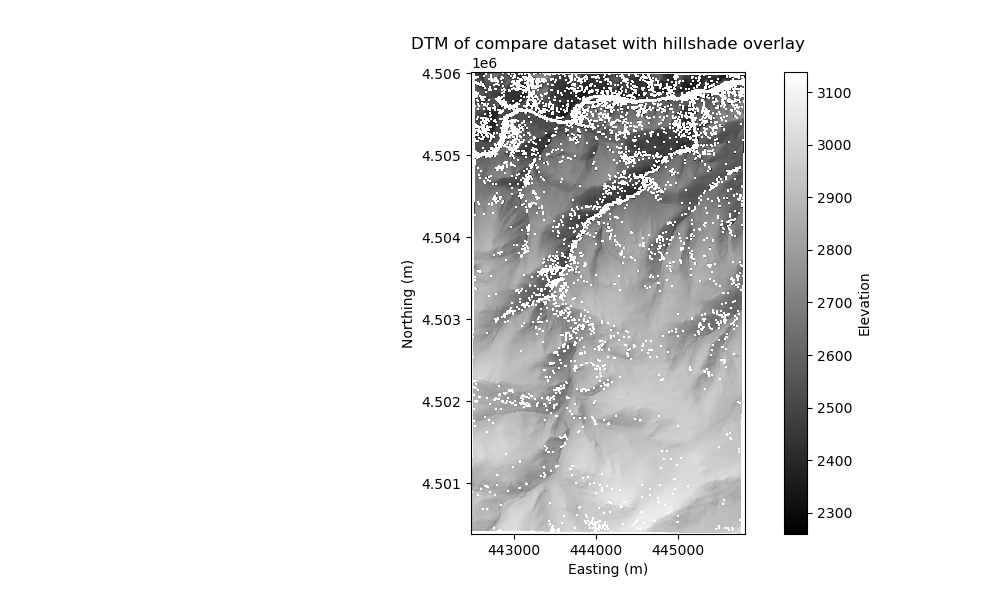

In [54]:
dem_path = compare_dtm
hillshade_path = hillshade_compare_dtm
title = "DTM of compare dataset with hillshade overlay"
colormap = "gray"
transparency_level = 0.4

plot_hillshade(dem_path, hillshade_path, title, colormap, transparency_level)

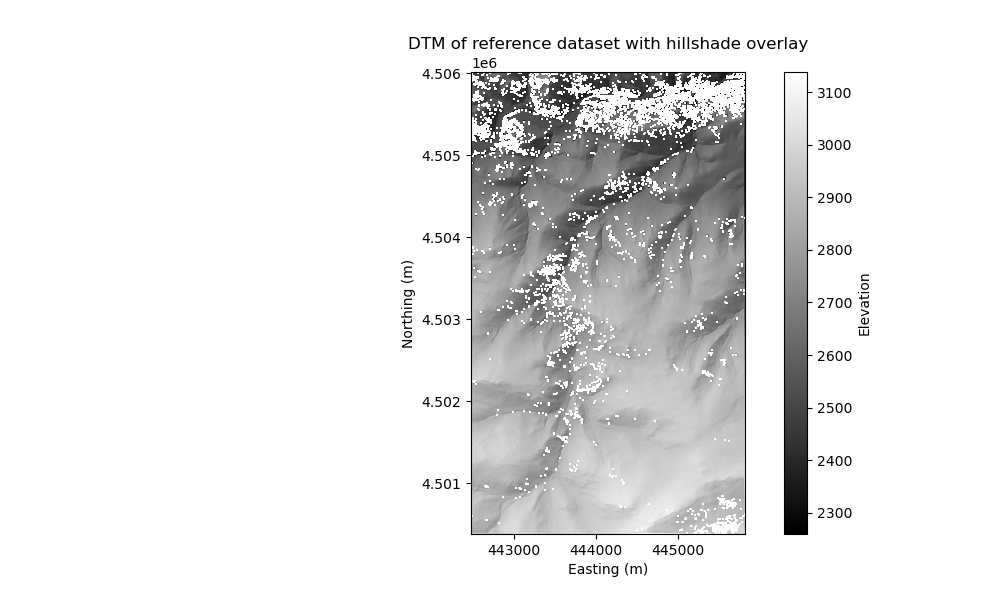

In [55]:
dem_path = reference_dtm
hillshade_path = hillshade_reference_dtm
title = "DTM of reference dataset with hillshade overlay"
colormap = "gray"
transparency_level = 0.4

plot_hillshade(dem_path, hillshade_path, title, colormap, transparency_level)

### Slope

In [56]:
# Paths to your input DEM and output slope files
slope_compare_dtm = data_path+'slope_dtm_compare.tif'
slope_compare_dsm = data_path+'slope_dsm_compare.tif'
slope_reference_dtm = data_path+'slope_dtm_reference.tif'
slope_reference_dsm = data_path+'slope_dsm_reference.tif'

# Call the function with the DEM files and output paths
calculate_slope(compare_dtm, slope_compare_dtm)
calculate_slope(compare_dsm, slope_compare_dsm)
calculate_slope(reference_dtm, slope_reference_dtm)
calculate_slope(reference_dsm, slope_reference_dsm)

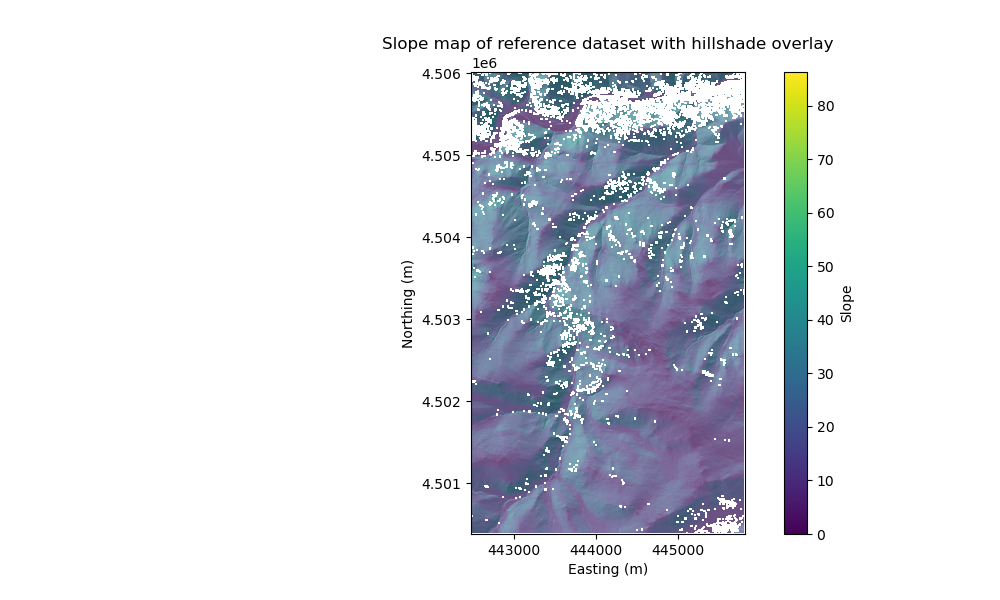

In [57]:
dem_path = reference_dtm
slope_path = slope_reference_dtm
title = "Slope map of reference dataset with hillshade overlay"
colormap = "viridis"
transparency_level = 0.4

plot_slope(dem_path, slope_path, title, colormap, transparency_level)

### Roughness

In [58]:
# Paths to your input DEM and output slope files
roughness_compare_dtm = data_path+'roughness_dtm_compare.tif'
roughness_compare_dsm = data_path+'roughness_dsm_compare.tif'
roughness_reference_dtm = data_path+'roughness_dtm_reference.tif'
roughness_reference_dsm = data_path+'roughness_dsm_reference.tif'

# Call the function with the DEM files and output paths
calculate_roughness(compare_dtm, roughness_compare_dtm)
calculate_roughness(compare_dsm, roughness_compare_dsm)
calculate_roughness(reference_dtm, roughness_reference_dtm)
calculate_roughness(reference_dsm, roughness_reference_dsm)

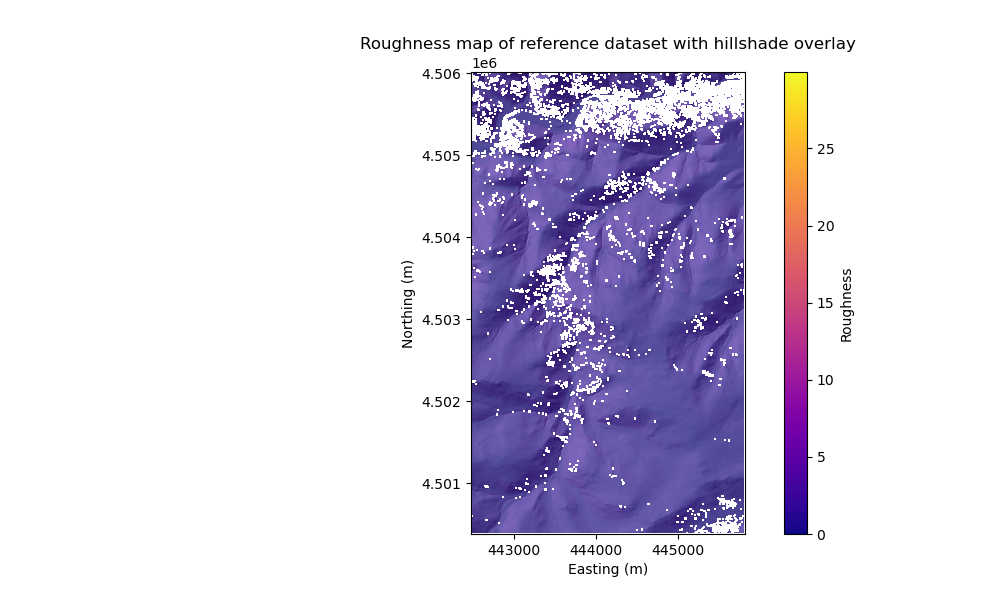

In [59]:
dem_path = reference_dtm
roughness_path = roughness_reference_dtm
title = "Roughness map of reference dataset with hillshade overlay"
colormap = "plasma"
transparency_level = 0.4

plot_roughness(dem_path, roughness_path, title, colormap, transparency_level)

### Aspect

In [60]:
# Paths to your input DEM and output slope files
aspect_compare_dtm = data_path+'aspect_dtm_compare.tif'
aspect_compare_dsm = data_path+'aspect_dsm_compare.tif'
aspect_reference_dtm = data_path+'aspect_dtm_reference.tif'
aspect_reference_dsm = data_path+'aspect_dsm_reference.tif'

# Call the function with the DEM files and output paths
calculate_aspect(compare_dtm, aspect_compare_dtm)
calculate_aspect(compare_dsm, aspect_compare_dsm)
calculate_aspect(reference_dtm, aspect_reference_dtm)
calculate_aspect(reference_dsm, aspect_reference_dsm)

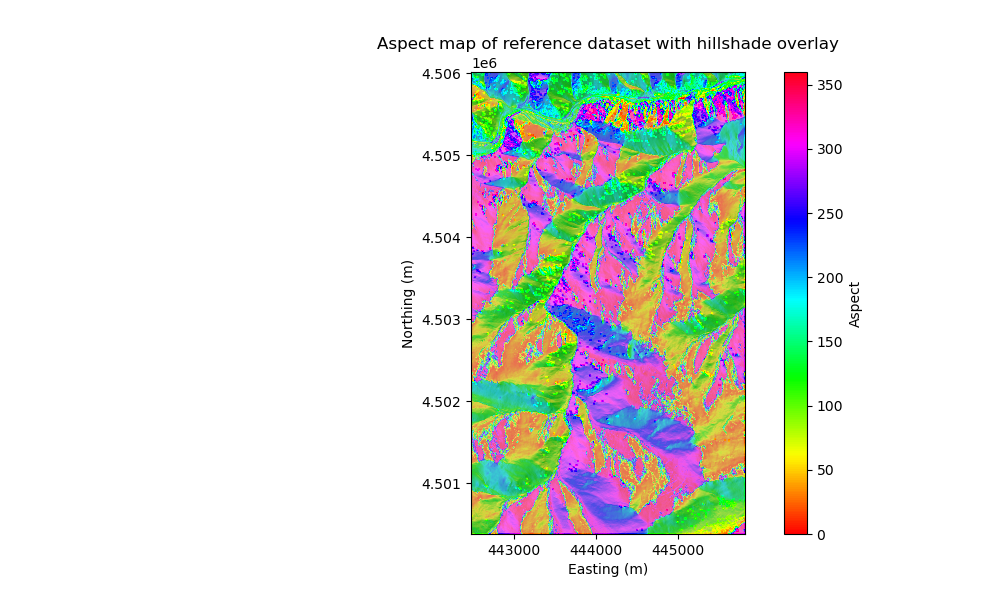

In [61]:
dem_path = reference_dtm
aspect_path = aspect_reference_dtm
title = "Aspect map of reference dataset with hillshade overlay"
colormap = "hsv"
transparency_level = 0.4

plot_aspect(dem_path, aspect_path, title, colormap, transparency_level)

### Canopy height models (compare and reference) 

In [62]:
try: 
    compare_dtm.close()
    reference_dtm.close()
    compare_dsm.close()
    reference_dsm.close()
    del compare_dtm
    del reference_dtm
    del compare_dsm
    del reference_dsm
except:
    pass

In [63]:
compare_dtm_rio = rio.open_rasterio(compare_dtm, masked=True) 
compare_dsm_rio = rio.open_rasterio(compare_dsm, masked=True)

compare_dtm_rio = compare_dtm_rio.assign_coords({
    "x": compare_dsm_rio.x,
    "y": compare_dsm_rio.y,
})

compare_chm_rio = compare_dsm_rio - compare_dtm_rio 
compare_chm_rio.compute()

compare_chm=data_path+"compare_chm.tif"
compare_chm_rio.rio.to_raster(compare_chm)

In [64]:
reference_dtm_rio = rio.open_rasterio(reference_dtm, masked=True) 
reference_dsm_rio = rio.open_rasterio(reference_dsm, masked=True)

reference_dtm_rio = reference_dtm_rio.assign_coords({
    "x": reference_dsm_rio.x,
    "y": reference_dsm_rio.y,
})

reference_chm_rio = reference_dsm_rio - reference_dtm_rio 
reference_chm_rio.compute()

reference_chm=data_path+"reference_chm.tif"
reference_chm_rio.rio.to_raster(reference_chm)

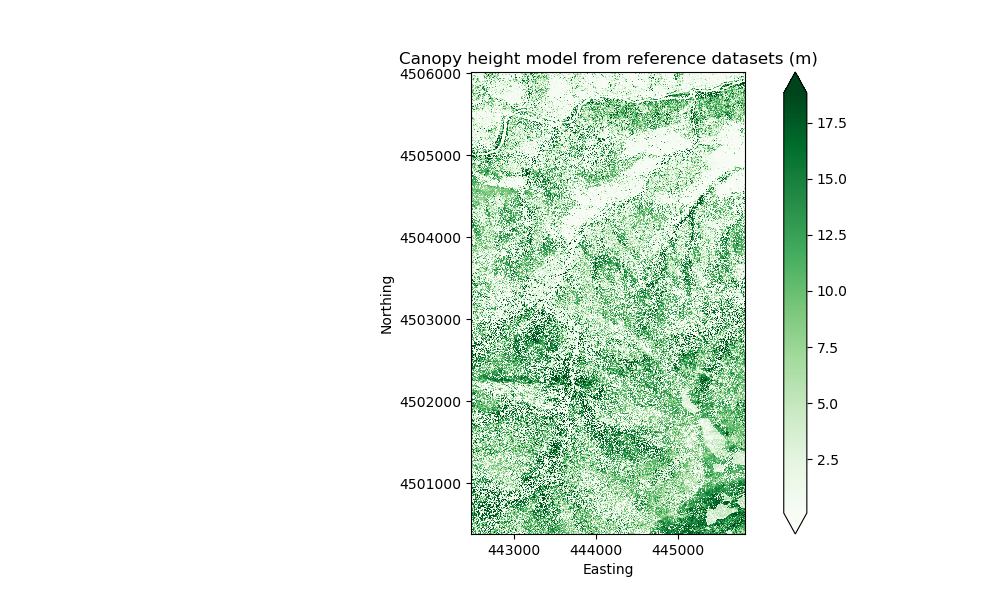

In [65]:
fig,ax=plt.subplots(figsize=(10, 6))
reference_chm_rio.plot(ax=ax,cmap="Greens", robust=True)
ax.set_title("Canopy height model from reference datasets (m)")
ax.set_xlabel('Easting')
ax.set_ylabel('Northing')
ax.ticklabel_format(style="plain")
ax.set_aspect('equal')

## Calculate Topographic Change with Raster Math
The following section is taken from <a href="https://github.com/cmspeed/OT_3DEP_Workflows/blob/main/notebooks/06_3DEP_Topographic_Differencing.ipynb">a notebook by Speed et al. (2022)</a>  

### Differencing DTMs

In [66]:
try: 
    compare_dtm.close()
    reference_dtm.close()
    topo_diff.close
    del compare_dtm
    del reference_dtm
    del topo_diff
except:
    pass

In [67]:
compare_dtm_rio = rio.open_rasterio(compare_dtm, masked=True) 
reference_dtm_rio = rio.open_rasterio(reference_dtm, masked=True)

In [68]:
print("Compare DTM has shape:", compare_dtm_rio.shape)
print("Reference DTM has shape:", reference_dtm_rio.shape)

Compare DTM has shape: (1, 5633, 3336)
Reference DTM has shape: (1, 5633, 3336)


In [69]:
if compare_dtm_rio.shape == reference_dtm_rio.shape:
    print('DTMs have the same shape. Proceed to the next step.')
elif compare_dtm_rio.shape > reference_dtm_rio.shape:
    small = reference_dtm
    large = compare_dtm
    compare_dtm_rio = compare_dtm_rio.rio.reproject_match(reference_dtm_rio)
    print("The smaller raster is {}. It has been used to clip the larger raster {}. Proceed to the next step.".format(small,large))
else:
    small = compare_dtm
    large = reference_dtm
    reference_dtm_rio = reference_dtm_rio.rio.reproject_match(compare_dtm_rio)
    print("The smaller raster is {}. It has been used to clip the larger raster {}. Proceed to the next step.".format(small,large))


DTMs have the same shape. Proceed to the next step.


In [70]:
print("Compare DTM has shape:", compare_dtm_rio.shape)
print("Reference DTM has shape:", reference_dtm_rio.shape)

Compare DTM has shape: (1, 5633, 3336)
Reference DTM has shape: (1, 5633, 3336)


In [71]:
compare_dtm_rio = compare_dtm_rio.assign_coords({
    "x": reference_dtm_rio.x,
    "y": reference_dtm_rio.y,
})

In [72]:
topo_diff = reference_dtm_rio - compare_dtm_rio
topo_diff.compute()
topo_diff_path=data_path+"topo_diff.tif"
topo_diff.rio.to_raster(topo_diff_path)

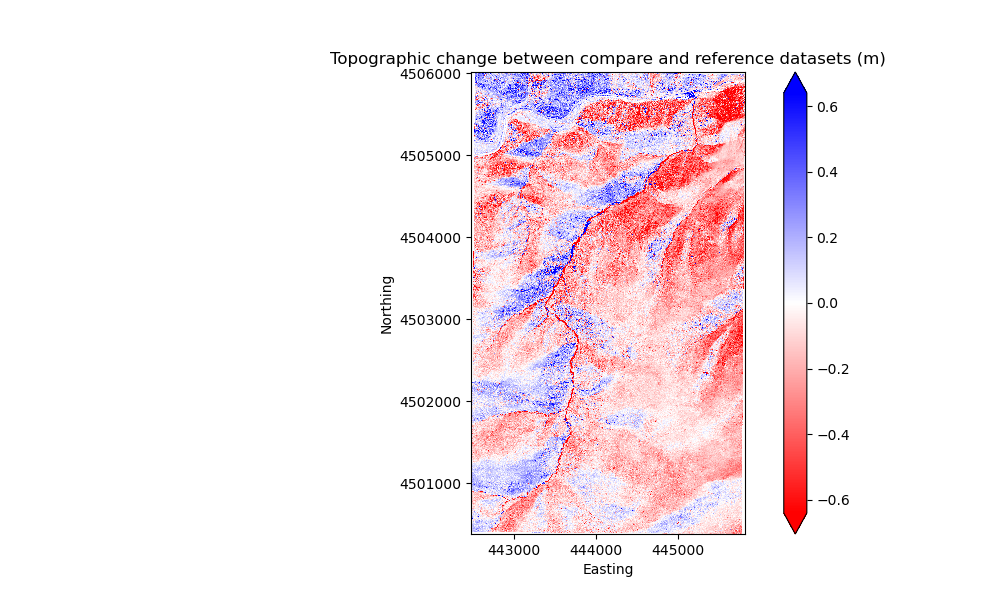

In [73]:
fig,ax=plt.subplots(figsize=(10, 6))
topo_diff.plot(ax=ax,cmap="bwr_r", robust=True)
ax.set_title("Topographic change between compare and reference datasets (m)")
ax.set_xlabel('Easting')
ax.set_ylabel('Northing')
ax.ticklabel_format(style="plain")
ax.set_aspect('equal')

In [74]:
try: 
    compare_dtm.close()
    reference_dtm.close()
    topo_diff.close
    del compare_dtm
    del reference_dtm
    del topo_diff
except:
    pass

In [75]:
def reproject_for_map (original_raster, new_raster):
    # Define source CRS and target CRS
    dst_crs = 'EPSG:3857' 
    with rasterio.open(original_raster) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        # Reproject and save the raster to a new file
        with rasterio.open(new_raster, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)

In [76]:
topo_diff = rio.open_rasterio(topo_diff_path, masked=True) 
hillshade_compare_dtm_rio = rio.open_rasterio(hillshade_compare_dtm, masked=True)

if topo_diff.shape > hillshade_compare_dtm_rio.shape:
    small = hillshade_compare_dtm
    large = topo_diff_path
    topo_diff = topo_diff.rio.reproject_match(hillshade_compare_dtm_rio)
else:
    small = topo_diff_path
    large = hillshade_compare_dtm
    hillshade_compare_dtm_rio = hillshade_compare_dtm_rio.rio.reproject_match(topo_diff)

topo_diff_path_cropped = data_path+'topo_diff_cropped.tif'
hillshade_compare_dtm_path_cropped = data_path+'hillshade_compare_dtm_cropped.tif'
  
topo_diff.rio.to_raster(topo_diff_path_cropped)
hillshade_compare_dtm_rio.rio.to_raster(hillshade_compare_dtm_path_cropped)

topo_diff_path_cropped_3857 = data_path+'topo_diff_cropped_epsg3857.tif'
hillshade_compare_dtm_path_cropped_3857 = data_path+'hillshade_compare_dtm_cropped_epsg3857.tif'

reproject_for_map (topo_diff_path_cropped, topo_diff_path_cropped_3857)
reproject_for_map (hillshade_compare_dtm_path_cropped, hillshade_compare_dtm_path_cropped_3857)

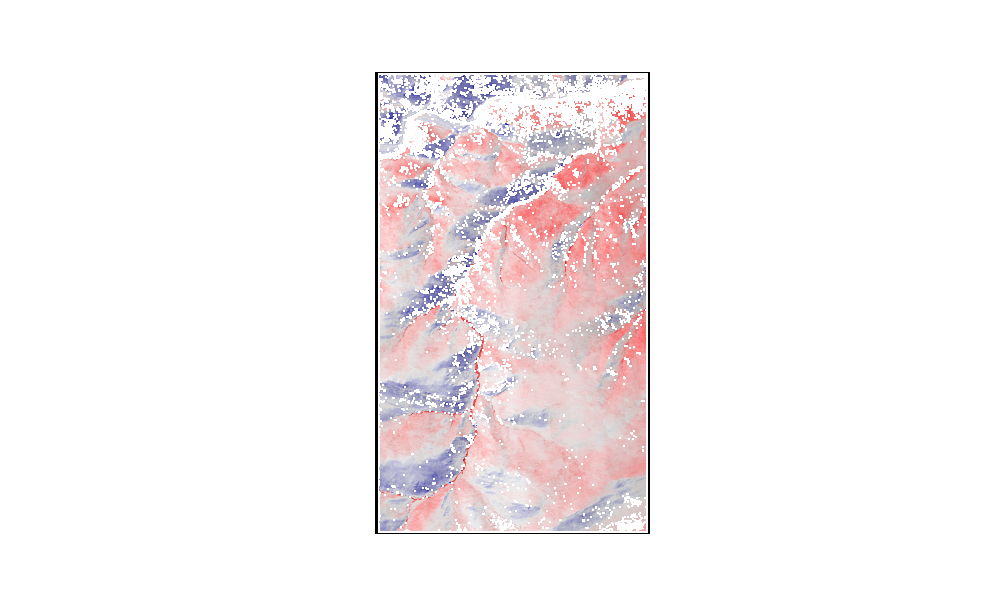

In [77]:
# Load the differencing data
with rasterio.open(topo_diff_path_cropped_3857, 'r+') as diff:
    diff.nodata = np.nan
    topo_diff = diff.read(1, masked=True)
    diff_extent = [diff.bounds.left, diff.bounds.right, diff.bounds.bottom, diff.bounds.top]
    topo_diff_mask = np.ma.getmask(topo_diff)  # Extract mask from topo_diff
    topo_mask = diff.read_masks(1)

#Load the hillshade data
with rasterio.open(hillshade_compare_dtm_path_cropped_3857) as data:
    hillshade = data.read(1, masked=True)
    # Apply topo_diff mask to hillshade data 
    hill_mask = data.read_masks(1) 

# Combine the masks from both datasets
combined_mask = np.logical_and(topo_mask, hill_mask)
inverse_mask = np.logical_not(combined_mask)

# Apply the combined mask to both datasets
topo_diff = np.ma.masked_where(inverse_mask, topo_diff, np.nan)
hillshade = np.ma.masked_where(inverse_mask, hillshade, np.nan)

# Plot the topographic differencing with colormap
fig, ax = plt.subplots(figsize=(10, 6))

def get_colormap_bounds(masked_array):
    data = masked_array.filled(fill_value=np.nan)
    data = data[~np.isnan(data)]
    data_98 = round(np.percentile(data,98), 1)
    data_2 = round(np.percentile(data,2), 1)
    if abs(data_98)>abs(data_2):
        vmax = abs(data_98)
        vmin = -abs(data_98)
    else:
        vmax = abs(data_2)
        vmin = -abs(data_2)
    return vmin,vmax

vmin, vmax = get_colormap_bounds(topo_diff) 
cmap_diff = plt.get_cmap('bwr_r')
cmap_diff.set_bad(color='none')  

# Normalize color
norm = Normalize(vmin=vmin, vmax=vmax)

# Display topographic differences
ax.imshow(topo_diff, cmap=cmap_diff, norm=norm, extent=diff_extent)

# Overlay the hillshade with the differencing results as a transparency layer
cmap_shade = plt.get_cmap('gray')
cmap_shade.set_bad(color='none')  # Ensure masked areas in hillshade are also not colored

ax.imshow(hillshade, cmap=cmap_shade, alpha=0.4, extent=diff_extent)

# Plotting the combined mask as its own layer
cmap_mask = plt.get_cmap('gray')  # Use a simple grayscale for the mask visualization
mask_display = np.where(inverse_mask, 1, np.nan)  # Convert boolean mask to a displayable format
ax.imshow(mask_display, cmap=cmap_mask, extent=diff_extent)

# Customize plot aesthetics
ax.axis('off')  # This removes axes border, ticks, and labels

# Save or show the plot
plt.savefig(data_path+'topo_diff.png', dpi=1200, bbox_inches='tight', pad_inches=0) 
plt.show() 


In [78]:

# Specify the path for the new masked raster file
mask_raster_path = data_path+'nodata_mask_compare_raster.tif'

# Open the original raster file to use its metadata for the new raster
with rasterio.open(topo_diff_path_cropped) as src:
    # Update the metadata for the new raster
    meta = src.meta.copy()
    meta.update({
        'dtype': 'uint8',
        'count': 1,
        'compress': 'lzw',
        'nodata': 0  # Assuming 0 for no-data in the mask; adjust as necessary
    })

    # Create a new raster file with the combined mask
    with rasterio.open(mask_raster_path, 'w', **meta) as dst:
        # Write the inverse mask to the raster, converting boolean to uint8
        dst.write(inverse_mask.astype('uint8') * 255, 1)  